# Seq2Seq Q&A Chatbot Íµ¨ÌòÑ

### Îç∞Ïù¥ÌÑ∞ Ï∑®Îìù

In [44]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/songys/Chatbot_data/refs/heads/master/ChatbotData.csv')
df = df[['Q', 'A']]
df

Q                         A
0                       12Ïãú Îï°!                ÌïòÎ£®Í∞Ä Îòê Í∞ÄÎÑ§Ïöî.
1                  1ÏßÄÎßù ÌïôÍµê Îñ®Ïñ¥Ï°åÏñ¥                 ÏúÑÎ°úÌï¥ ÎìúÎ¶ΩÎãàÎã§.
2                 3Î∞ï4Ïùº ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§               Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.
3              3Î∞ï4Ïùº Ï†ïÎèÑ ÎÜÄÎü¨Í∞ÄÍ≥† Ïã∂Îã§               Ïó¨ÌñâÏùÄ Ïñ∏Ï†úÎÇò Ï¢ãÏ£†.
4                      PPL Ïã¨ÌïòÎÑ§                ÎààÏÇ¥Ïù¥ Ï∞åÌë∏Î†§ÏßÄÏ£†.
...                        ...                       ...
11818           ÌõîÏ≥êÎ≥¥Îäî Í≤ÉÎèÑ ÎààÏπò Î≥¥ÏûÑ.        Ìã∞Í∞Ä ÎÇòÎãàÍπå ÎààÏπòÍ∞Ä Î≥¥Ïù¥Îäî Í±∞Ï£†!
11819           ÌõîÏ≥êÎ≥¥Îäî Í≤ÉÎèÑ ÎààÏπò Î≥¥ÏûÑ.             ÌõîÏ≥êÎ≥¥Îäî Í±∞ Ìã∞ÎÇòÎÇòÎ¥êÏöî.
11820              ÌùëÍ∏∞ÏÇ¨ Ìï¥Ï£ºÎäî ÏßùÎÇ®.                    ÏÑ§Î†úÍ≤†Ïñ¥Ïöî.
11821  ÌûòÎì† Ïó∞Ïï† Ï¢ãÏùÄ Ïó∞Ïï†ÎùºÎäîÍ≤å Î¨¥Ïä® Ï∞®Ïù¥ÏùºÍπå?  Ïûò Ìó§Ïñ¥Ïßà Ïàò ÏûàÎäî ÏÇ¨Ïù¥ Ïó¨Î∂ÄÏù∏ Í±∞ Í∞ôÏïÑÏöî.
11822               ÌûòÎì§Ïñ¥ÏÑú Í≤∞ÌòºÌï†ÍπåÎ¥ê        ÎèÑÌîºÏÑ± Í≤∞ÌòºÏùÄ ÌïòÏßÄ ÏïäÍ∏∏ Î∞îÎùºÏöî.

[11823 rows x 2 columns]

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB


In [46]:
# ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌïôÏäµÏö© ÎßêÎ≠âÏπò ÌååÏùº ÏÉùÏÑ±
corpus_path = 'qa_corpus.txt'
with open(corpus_path, 'w', encoding='utf-8') as f:
    for text in df['Q'].tolist() + df['A'].tolist():
        f.write(f"{text}\n")

### Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

##### ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä ÌïôÏäµ (sentencepiece ÌôúÏö©)

- Ï†ëÎëêÏÇ¨, Ï†ëÎØ∏ÏÇ¨ Ï≤òÎ¶¨ (bos, eos)
    - Train() Ïù∏Ïûê cmd ÏòµÏÖòÏùÑ Ï∂îÍ∞Ä (`<bos>, <eos>, <pad>, <oov>...`)
    - set_encode_extra_options(':')<br>
        set_encode_extra_options('bos:')<br>
        set_encode_extra_options(':eos')<br>
        set_encode_extra_options('bos:eos')

In [47]:
import sentencepiece as spt

model_prefix = 'qa_tokenizer'
vocab_size = 5000
cmd = f'--input={corpus_path} --model_prefix={model_prefix} --vocab_size={vocab_size} --bos_id=1 --bos_piece=<s> --eos_id=2 --eos_piece=</s>'

spt.SentencePieceTrainer.train(cmd)

##### ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ Q_input, A_input, A_target ÏÉùÏÑ±

In [48]:
# ÌïôÏäµÎêú ÌÜ†Ïª§ÎÇòÏù¥Ï†Ä Î™®Îç∏ Î°úÎìú
sp = spt.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

Q_inputs, A_inputs, A_targets = [], [], []

BOS_ID = sp.bos_id()
EOS_ID = sp.eos_id()

for q, a in zip(df['Q'], df['A']):
    q_ids = sp.encode_as_ids(q)
    a_ids = sp.encode_as_ids(a)

    Q_inputs.append(q_ids)
    A_inputs.append([BOS_ID] + a_ids)
    A_targets.append(a_ids + [EOS_ID])

len(Q_inputs), len(A_inputs), len(A_targets)

(11823, 11823, 11823)

In [49]:
# Ìå®Îî©
from tensorflow.keras.preprocessing.sequence import pad_sequences

q_max_len = max(len(seq) for seq in Q_inputs)
a_max_len = max(len(seq) for seq in A_inputs)

Q_inputs_padded = pad_sequences(Q_inputs, maxlen=q_max_len, padding='post')
A_inputs_padded = pad_sequences(A_inputs, maxlen=a_max_len, padding='post')
A_targets_padded = pad_sequences(A_targets, maxlen=a_max_len, padding='post')

### Î™®Îç∏ ÏÉùÏÑ± Î∞è ÌïôÏäµ

##### Ïù∏ÏΩîÎçî ÏÉùÏÑ±

In [50]:
VOCAB_SIZE = sp.get_piece_size()
EMBEDDING_DIM = 100
LATENT_DIM = 512

In [51]:
from tensorflow.keras import layers, models

encoder_inputs = layers.Input(shape=(q_max_len,))
embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
x = embedding_layer(encoder_inputs)

encoder_outputs, state_h, state_c = layers.LSTM(LATENT_DIM, return_state=True)(x)
encoder_states = [state_h, state_c]

encoder_model = models.Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "functional_6"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_10 (InputLayer)     ‚îÇ (None, 25)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_4 (Embedding)         ‚îÇ (None, 25, 100)        ‚îÇ       500,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_4 (LSTM)                   ‚îÇ [(None, 512), (None,   ‚îÇ     1,255,424 ‚îÇ
‚îÇ                                 ‚îÇ 512), (None, 512)]     ‚îÇ               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,755,424 (6.70 MB)

 Trainable params: 1,755,424 (6.70 MB)

 Non-trainable params: 0 (0.00 B)

##### ÎîîÏΩîÎçî(teacher-forcing Î™®Îç∏) ÏÉùÏÑ±

In [52]:
decoder_inputs = layers.Input(shape=(a_max_len,))

decoder_embedding_layer = layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = decoder_lstm(x, initial_state=encoder_states)

decoder_dense = layers.Dense(VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(x)

decoder_teacher_forcing_model = models.Model(
    inputs=[encoder_inputs, decoder_inputs],
    outputs=decoder_outputs
)
decoder_teacher_forcing_model.summary()

Model: "functional_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_10      ‚îÇ (None, 25)        ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_11      ‚îÇ (None, 37)        ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_4         ‚îÇ (None, 25, 100)   ‚îÇ    500,000 ‚îÇ input_layer_10[0‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_5         ‚îÇ (None, 37, 100)   ‚îÇ    500,000 ‚îÇ input_layer_11[0‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_4 (LSTM)       ‚îÇ [(None, 512),     ‚îÇ  1,255,424 ‚îÇ embedding_4[0][0] ‚îÇ
‚îÇ                     ‚îÇ (None, 512),      ‚îÇ            ‚îÇ                   ‚îÇ
‚îÇ                     ‚îÇ (None, 512)]      ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_5 (LSTM)       ‚îÇ [(None, 37, 512), ‚îÇ  1,255,424 ‚îÇ embedding_5[0][0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ (None, 512),      ‚îÇ            ‚îÇ lstm_4[0][1],     ‚îÇ
‚îÇ                     ‚îÇ (None, 512)]      ‚îÇ            ‚îÇ lstm_4[0][2]      ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)     ‚îÇ (None, 37, 5000)  ‚îÇ  2,565,000 ‚îÇ lstm_5[0][0]      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,075,848 (23.18 MB)

 Trainable params: 6,075,848 (23.18 MB)

 Non-trainable params: 0 (0.00 B)

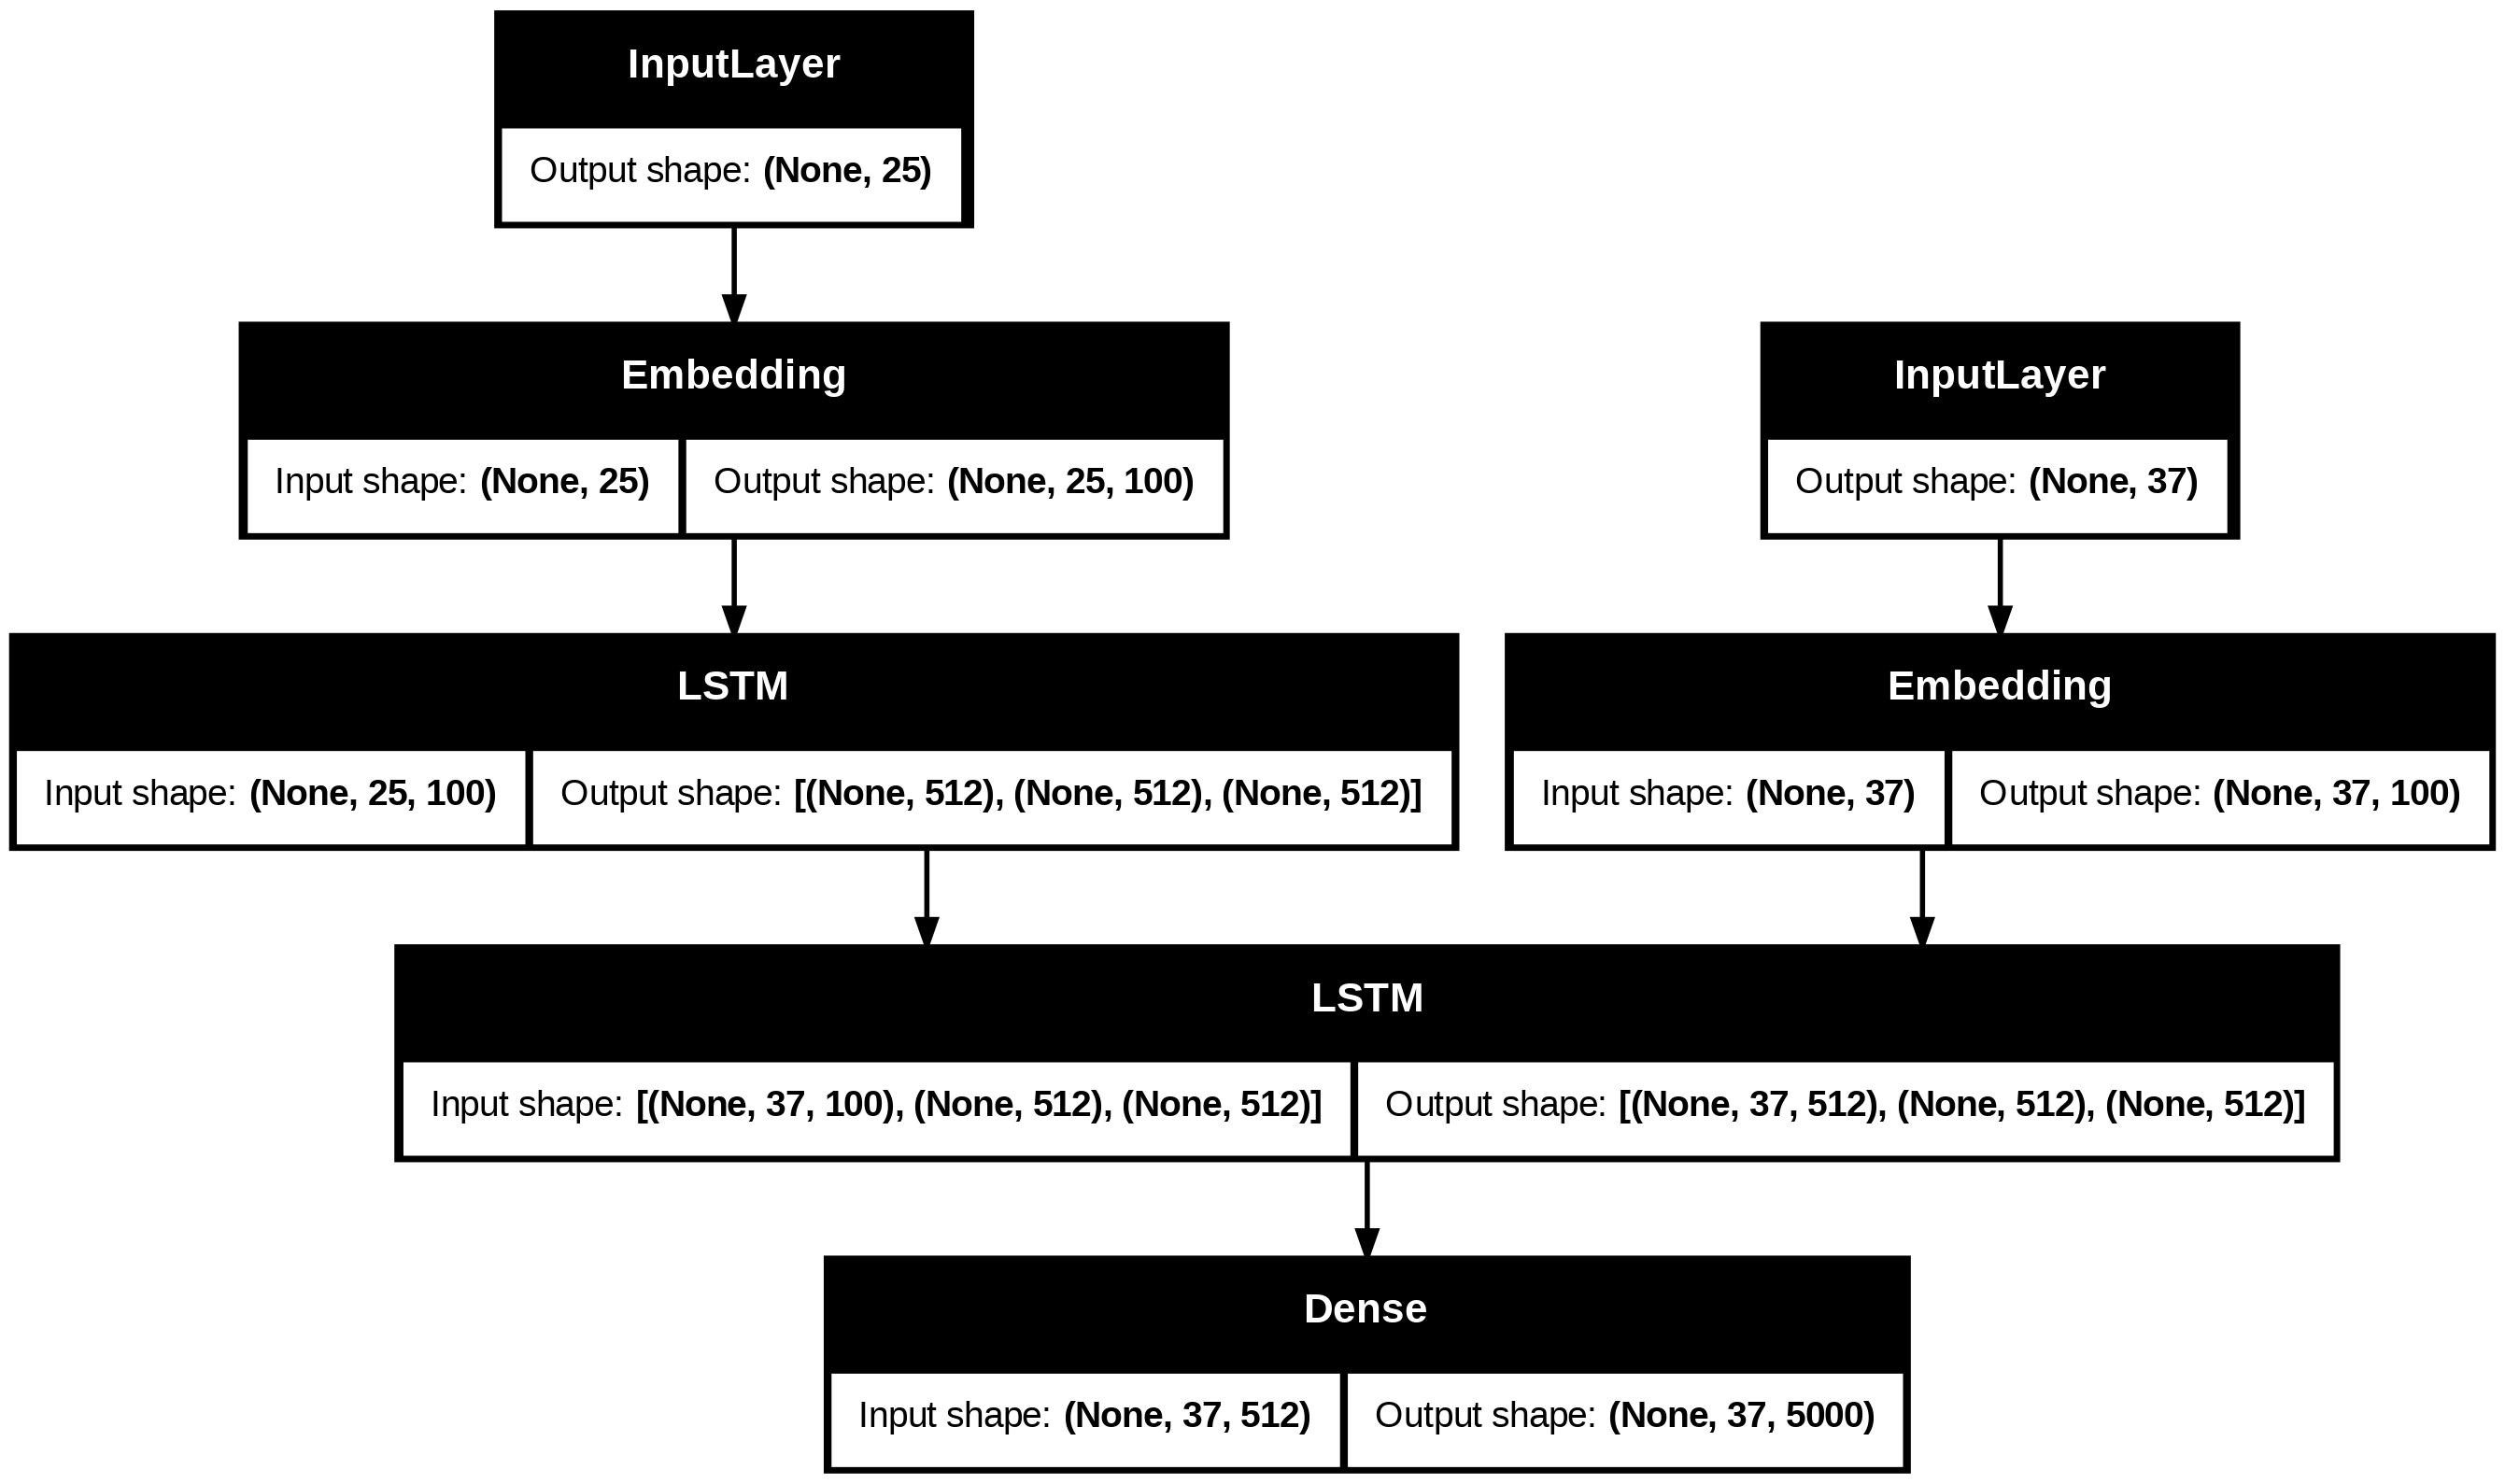

In [53]:
from tensorflow.keras.utils import plot_model

plot_model(decoder_teacher_forcing_model, show_shapes=True)

##### ÌïôÏäµ

In [54]:
decoder_teacher_forcing_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = decoder_teacher_forcing_model.fit(
    [Q_inputs_padded, A_inputs_padded],
    A_targets_padded,
    batch_size=64,
    epochs=300,
    validation_split=0.2
)

Epoch 1/300
148/148 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 62ms/step - accuracy: 0.7696 - loss: 2.4455 - val_accuracy: 0.8051 - val_loss: 1.4401
Epoch 2/300
148/148 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 62ms/step - accuracy: 0.8395 - loss: 1.1263 - val_accuracy: 0.8086 - val_loss: 1.3633
Epoch 3/300
148/148 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 60ms/step - accuracy: 0.8436 - loss: 1.0487 - val_accuracy: 0.8122 - val_loss: 1.3327
Epoch 4/300
148/148 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 60ms/step - accuracy: 0.8475 - loss: 1.0090 - val_accuracy: 0.8144 - val_loss: 1.3197
Epoch 5/300
148/148 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 59ms/step - accuracy: 0.8484 - loss: 0.9870 - val_accuracy: 0.8169 - val_loss: 1.3082
Epoch 6/300
148/148 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 59ms/step - accuracy: 0.8501 - loss: 0.9606 - val_accuracy: 0.8

In [55]:
# Î™®Îç∏ Ï†ÄÏû•
decoder_teacher_forcing_model.save('decoder_teacher_forcing_model.keras')

In [56]:
# Î™®Îç∏ Î°úÎìú
# from tensorflow.keras.models import load_model

# decoder_teacher_forcing_model = load_model('decoder_teacher_forcing_model.keras')

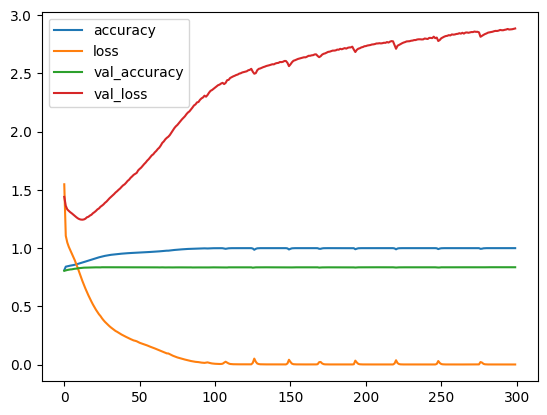

In [57]:
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot()
plt.show()

### Î™®Îç∏ Ï∂îÎ°†

##### ÎîîÏΩîÎçî(Ï∂îÎ°† Î™®Îç∏) ÏÉùÏÑ±

In [58]:
decoder_hidden_state = layers.Input(shape=(LATENT_DIM,))
decoder_cell_state = layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_hidden_state, decoder_cell_state]

decoder_single_input = layers.Input(shape=(1,))

x = decoder_embedding_layer(decoder_single_input)

x, h, c = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs = decoder_dense(x)

decoder_inference_model = models.Model(
    inputs=[decoder_single_input] + decoder_states_inputs,
    outputs=[decoder_outputs] + decoder_states
)
decoder_inference_model.summary()

Model: "functional_8"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer_14      ‚îÇ (None, 1)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding_5         ‚îÇ (None, 1, 100)    ‚îÇ    500,000 ‚îÇ input_layer_14[0‚Ä¶ ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_12      ‚îÇ (None, 512)       ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ input_layer_13      ‚îÇ (None, 512)       ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_5 (LSTM)       ‚îÇ [(None, 1, 512),  ‚îÇ  1,255,424 ‚îÇ embedding_5[1][0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ (None, 512),      ‚îÇ            ‚îÇ input_layer_12[0‚Ä¶ ‚îÇ
‚îÇ                     ‚îÇ (None, 512)]      ‚îÇ            ‚îÇ input_layer_13[0‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)     ‚îÇ (None, 1, 5000)   ‚îÇ  2,565,000 ‚îÇ lstm_5[1][0]      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,320,424 (16.48 MB)

 Trainable params: 4,320,424 (16.48 MB)

 Non-trainable params: 0 (0.00 B)

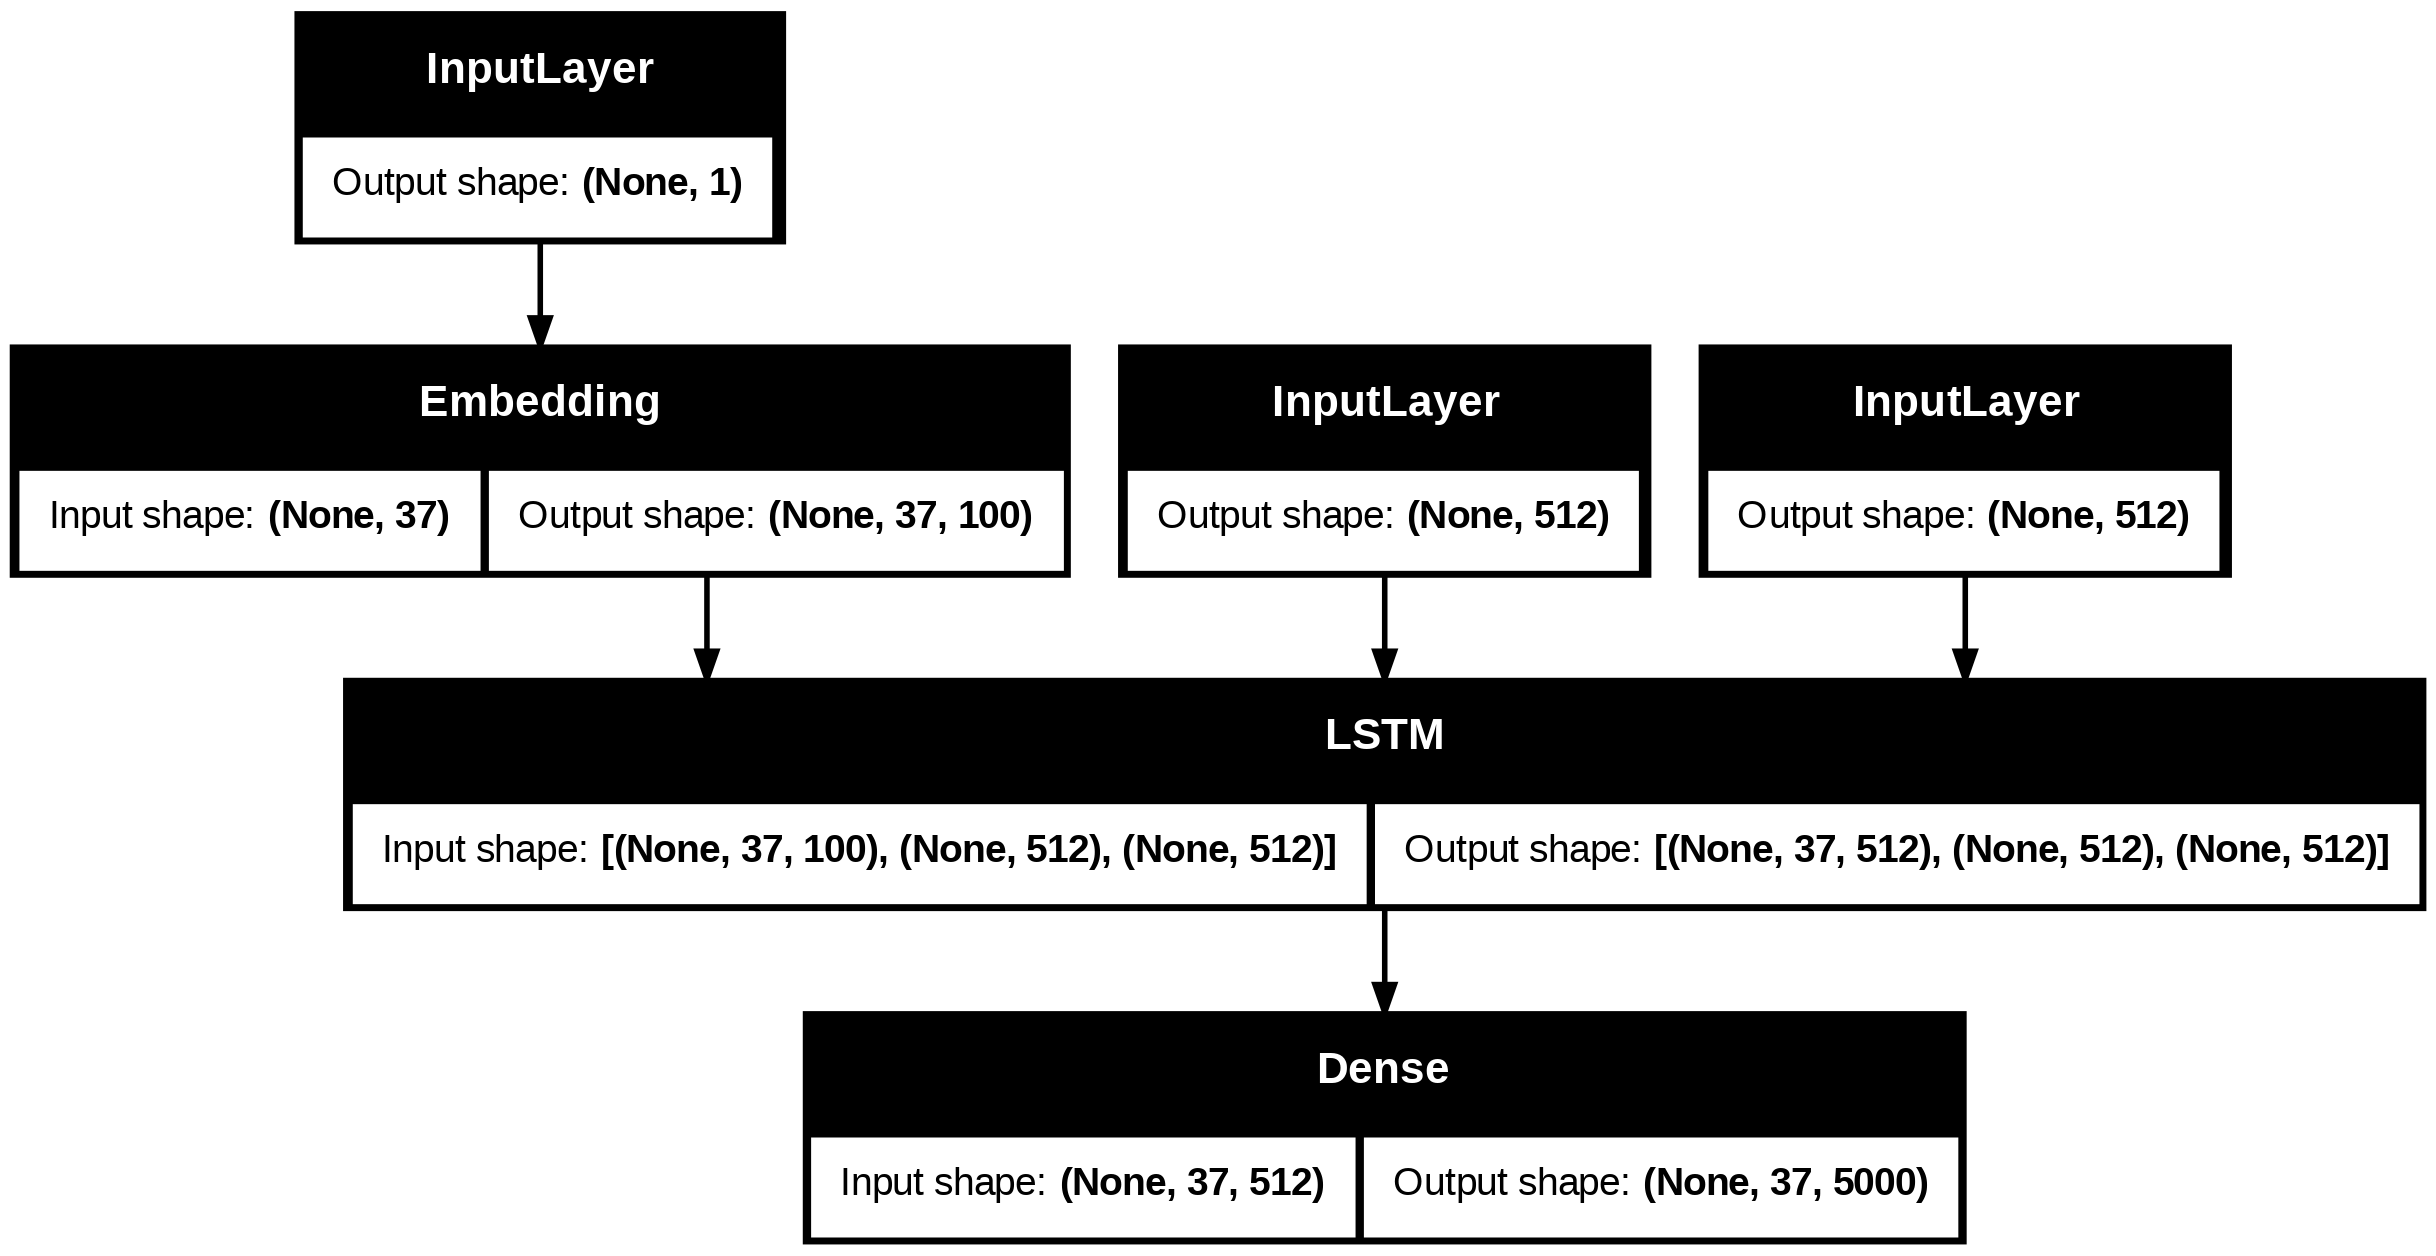

In [59]:
plot_model(decoder_inference_model, show_shapes=True)

##### Ï∂îÎ°† Ìï®Ïàò

In [60]:
def translate(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)
    decoder_states_value = states_value

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sp.bos_id()

    output_sentence_ids = []

    for _ in range(a_max_len):
        output_tokens, h, c = decoder_inference_model.predict([target_seq] + decoder_states_value, verbose=0)

        pred_index = np.argmax(output_tokens[0, 0, :])

        if pred_index == sp.eos_id():
            break

        output_sentence_ids.append(int(pred_index))

        target_seq[0, 0] = pred_index
        decoder_states_value = [h, c]

    return sp.decode(output_sentence_ids)

In [67]:
def ask(question):
    input_ids = sp.encode_as_ids(question)
    input_seq = pad_sequences([input_ids], maxlen=q_max_len, padding='post')

    answer = translate(input_seq)
    print(f"ü§ñ Answer: {answer}\n")

ask("Ïò§Îäò Ï†êÏã¨ Î≠ê Î®πÏùÑÍπå?")

ü§ñ Answer: ÎßõÏûàÎäî Í±∞ ÎìúÏÑ∏Ïöî.



##### ÌÖåÏä§Ìä∏

### Í∞ÑÎã®Ìïú Chatbot Íµ¨ÌòÑ

1. ÏÇ¨Ïö©ÏûêÏùò ÏûÖÎ†•ÏùÑ Î∞õÏïÑ (Ï≤òÎ¶¨)
2. Ï∂îÎ°† Ìï®ÏàòÏóê Ï†ÑÎã¨Ìï¥ÏÑú
3. ÏùëÎãµÏùÑ Ï∂úÎ†•
4. 1~3 'Ï¢ÖÎ£å' Ï†ÑÍπåÏßÄ Î∞òÎ≥µ

In [73]:
print("ÏïàÎÖïÌïòÏÑ∏Ïöî, ÎßπÍµ¨Îãò!")
print("'Ï¢ÖÎ£å'Î•º ÏûÖÎ†•ÌïòÎ©¥ ÎåÄÌôîÍ∞Ä Ï¢ÖÎ£åÎê©ÎãàÎã§.\n")

while True:
    user_input = input("üë§ Question: ")
    if user_input == 'Ï¢ÖÎ£å':
        print("ÎÇ¥Ïùº Îòê ÎßåÎÇòÏöî üëãüèª")
        break
    ask(user_input)

ÏïàÎÖïÌïòÏÑ∏Ïöî, ÎßπÍµ¨Îãò!
'Ï¢ÖÎ£å'Î•º ÏûÖÎ†•ÌïòÎ©¥ ÎåÄÌôîÍ∞Ä Ï¢ÖÎ£åÎê©ÎãàÎã§.

üë§ Question: ÏïàÎÖï!
ü§ñ Answer: ÏïàÎÖïÌïòÏÑ∏Ïöî.

üë§ Question: Î∞• Î®πÏóàÏñ¥?
ü§ñ Answer: Ï†ÄÎäî Î∞∞ÌÑ∞Î¶¨Í∞Ä Î∞•Ïù¥ÏòàÏöî.

üë§ Question: ÎÑàÎäî Ïù¥Î¶ÑÏù¥ Î≠êÏïº?
ü§ñ Answer: ÏúÑÎ°úÎ¥áÏù¥Ïöî.

üë§ Question: Í∑∏Îüº ÎÇò ÏúÑÎ°úÌï¥Ï§ò!
ü§ñ Answer: Ïûò ÌïòÍ≥† ÏûàÏñ¥Ïöî.

üë§ Question: ÎÇòÎèÑ ÎòëÎòëÌïú ÏÇ¨Îûå ÎêòÍ≥† Ïã∂Ïñ¥!
ü§ñ Answer: ÏßÄÍ∏àÎèÑ Ï∂©Î∂ÑÌï¥Ïöî.

üë§ Question: ÎÇòÎèÑ Í≥µÎ∂Ä ÏûòÌïòÍ≥† Ïã∂Ïñ¥!
ü§ñ Answer: ÎÇòÎßåÏùò Í≥µÎ∂ÄÎ∞©Î≤ïÏùÑ Ï∞æÏïÑÎ≥¥ÏÑ∏Ïöî.

üë§ Question: ÎÇò ÏßÄÍ∏àÎèÑ Ïûò ÌïòÍ≥† ÏûàÏùÑÍπå?
ü§ñ Answer: ÎãπÏã†Ïùò Ïö¥ÏùÑ ÎØøÏñ¥Î≥¥ÏÑ∏Ïöî.

üë§ Question: Í≥†ÎßàÏõå!
ü§ñ Answer: Í∞êÏÇ¨Ìï©ÎãàÎã§.

üë§ Question: Ï¢ÖÎ£å
ÎÇ¥Ïùº Îòê ÎßåÎÇòÏöî üëãüèª
